# Setup and Install

In [ ]:
!pip install roboflow ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 143.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


# YOLOV11n Training

In [ ]:
import os
import shutil
import torch
from google.colab import drive
from roboflow import Roboflow
from ultralytics import settings, YOLO

drive.mount('/content/drive')

DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/Deep_Learning'
DRIVE_WEIGHTS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'weights')
DRIVE_RUNS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'runs')

os.makedirs(DRIVE_WEIGHTS_DIR, exist_ok=True) # Create weights directory if it doesn't exist
os.makedirs(DRIVE_RUNS_DIR, exist_ok=True)

settings.update({'datasets_dir': '/content/datasets'})

def download_data_fast():
    print("Downloading dataset from Roboflow to local Colab disk")

    rf = Roboflow(api_key="8gFJp7Eu2sWslubjUHwI")
    project = rf.workspace("visualizan2").project("c1-zhnfm")
    version = project.version(1)

    dataset = version.download("yolov11")

    print(f"Dataset ready at: {dataset.location}")
    return dataset, f"{dataset.location}/data.yaml"

# Start download
dataset_obj, data_yaml_path = download_data_fast()

local_dataset = '/content/local_dataset'

def merge_datasets(source_root, target_root):
    # Iterate through 'train', 'valid', and 'test' sets
    for subset in ['train', 'valid', 'test']:
        for folder in ['images', 'labels']:
            source_dir = os.path.join(source_root, subset, folder)
            target_dir = os.path.join(target_root, subset, folder)

            # Check if source directory exists
            if os.path.exists(source_dir) and os.path.exists(target_dir):
                files = os.listdir(source_dir)
                print(f"--> Copying {len(files)} files to: {subset}/{folder}")

                for file_name in files:
                    full_file_name = os.path.join(source_dir, file_name)
                    if os.path.isfile(full_file_name):
                        shutil.copy(full_file_name, target_dir)
            else:
                pass

# Check if manual path exists and run the merge
if os.path.exists(local_dataset):
    merge_datasets(local_dataset, dataset_obj.location)
else:
    print(f"WARNING: local dataset path not found: {local_dataset}. Proceeding with Roboflow data only.")

model = YOLO('yolo11n.pt')

run_name = 'chess_yolo11_nano_v1'

results = model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer='AdamW',
    lr0=0.001,
    cos_lr=True,
    project='/content/runs/detect',
    name=run_name,
    seed=42,
    patience=15,
    plots=True
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C1-1 in yolov11:: 100%|██████████| 19546/19546 [00:02<00:00, 7431.33it/s]


Dataset ready at: /content/C1-1
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/C1-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_yolo11_nano_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

# Save Results to Drive

In [ ]:
import datetime

def backup_to_drive():
    print("Training completed. Backing up results to Google Drive...")

    # Local results directory
    local_dir = f'/content/runs/detect/{run_name}'

    drive_dest = os.path.join(DRIVE_RUNS_DIR, f"{run_name}")

    # Copy entire run folder
    shutil.copytree(local_dir, drive_dest)

    # copy the best model separately to weights directory
    best_pt = os.path.join(local_dir, 'weights', 'best.pt')
    if os.path.exists(best_pt):
        shutil.copy(best_pt, os.path.join(DRIVE_WEIGHTS_DIR, f"best_{run_name}.pt"))
        print(f"Best model copied to: {DRIVE_WEIGHTS_DIR}")

backup_to_drive()

Training completed. Backing up results to Google Drive...
Best model copied to: /content/drive/MyDrive/Deep_Learning/weights


# Show Training Metrics

 Inspecting results from: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11_nano_v1
Test images found in Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

==================== 1. TRAINING METRICS ====================

--- Loss & Metrics Curves ---


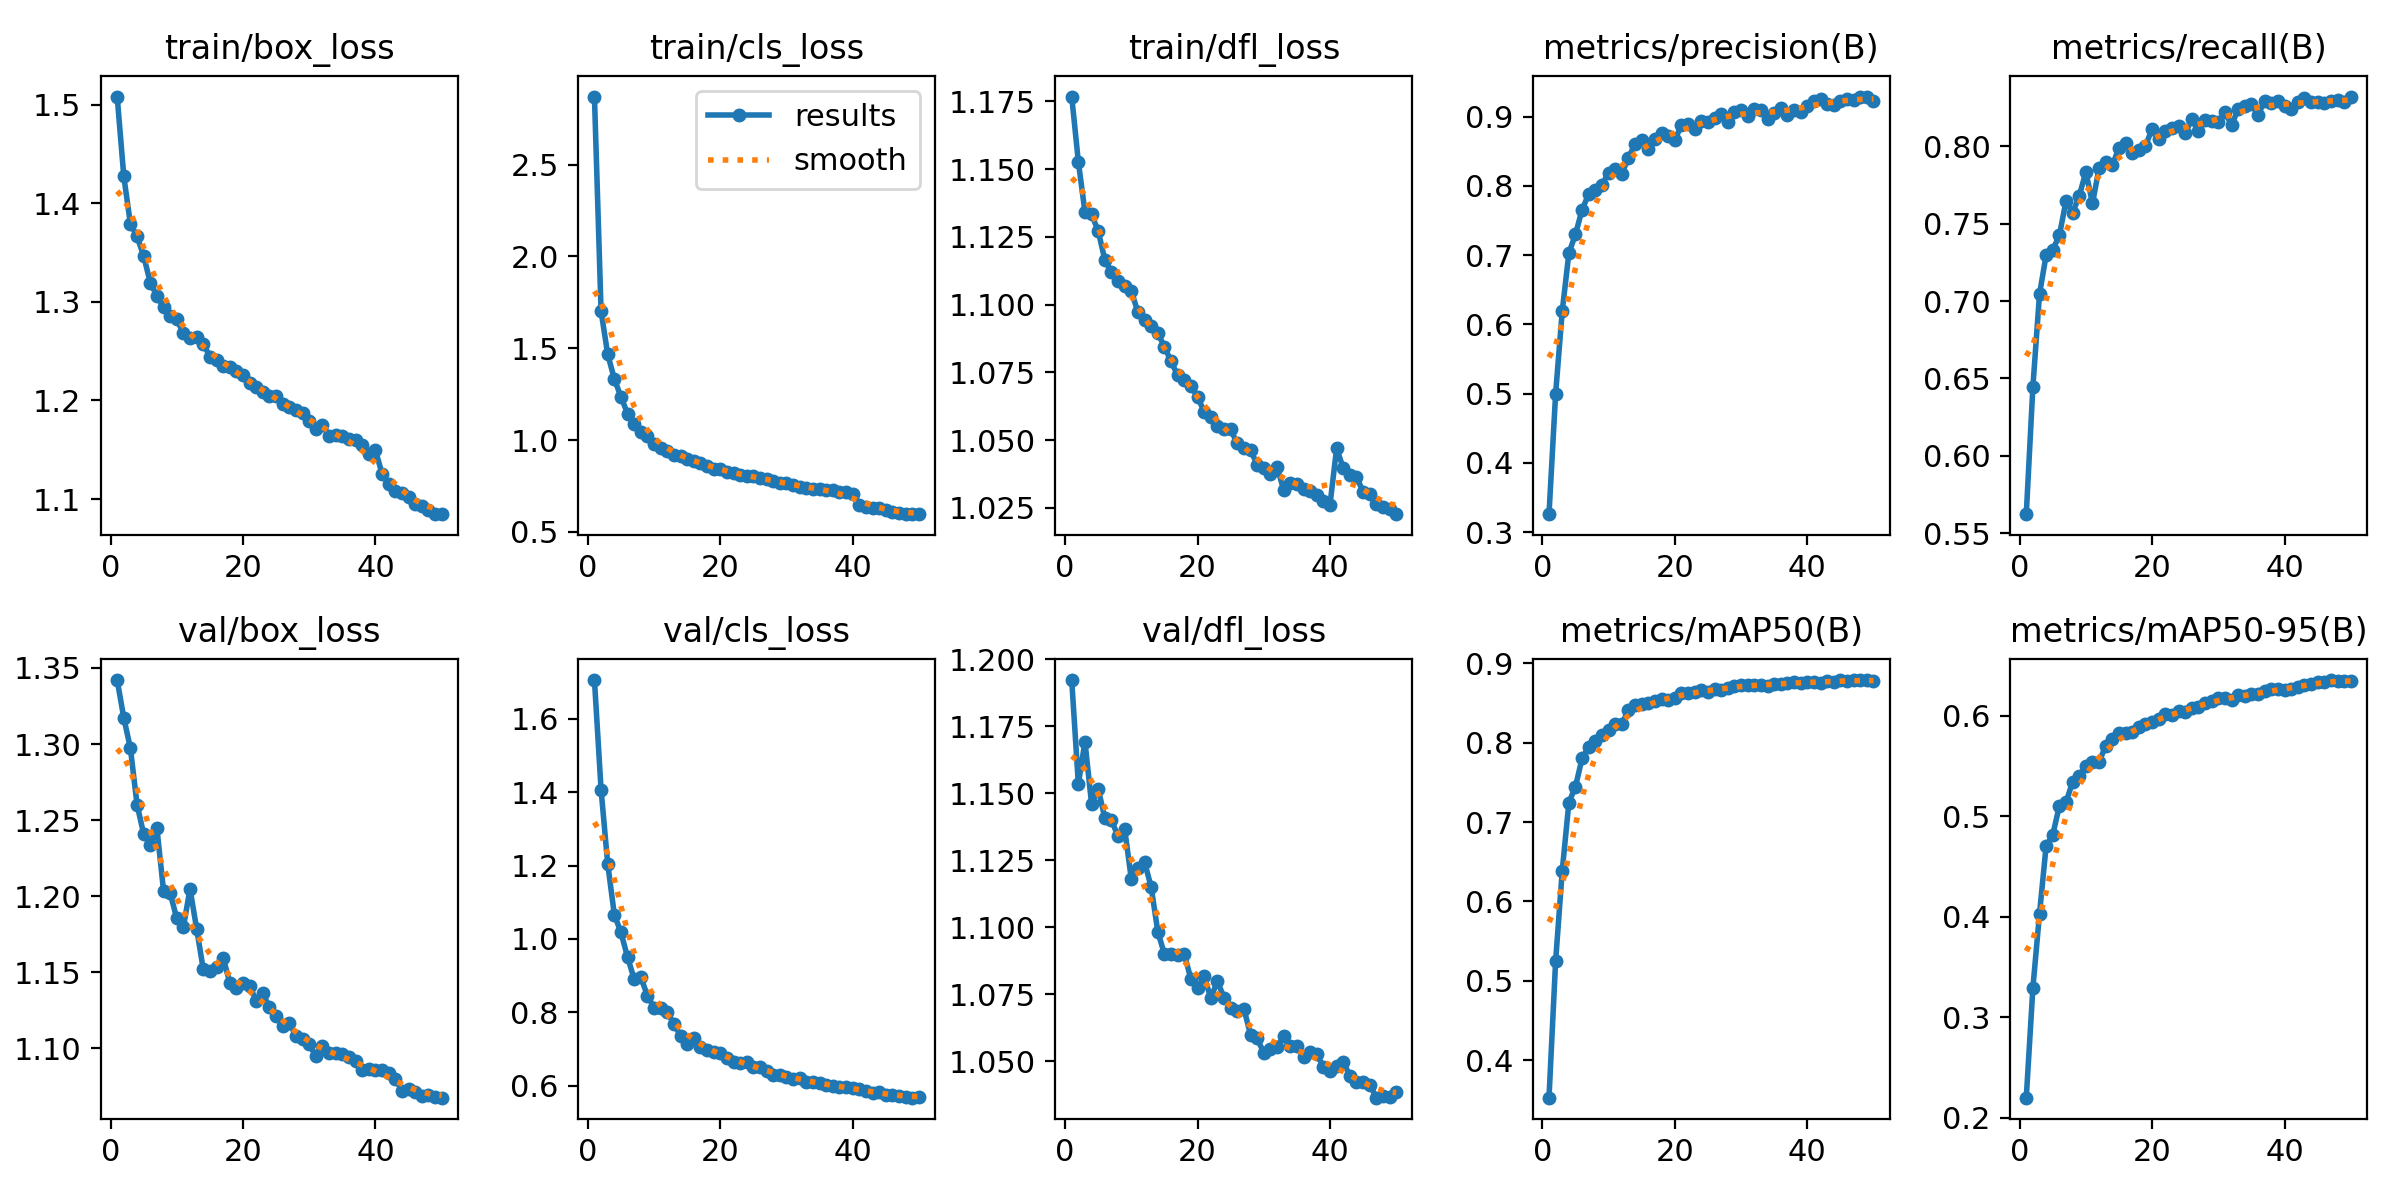


--- Confusion Matrix (Normalized) ---


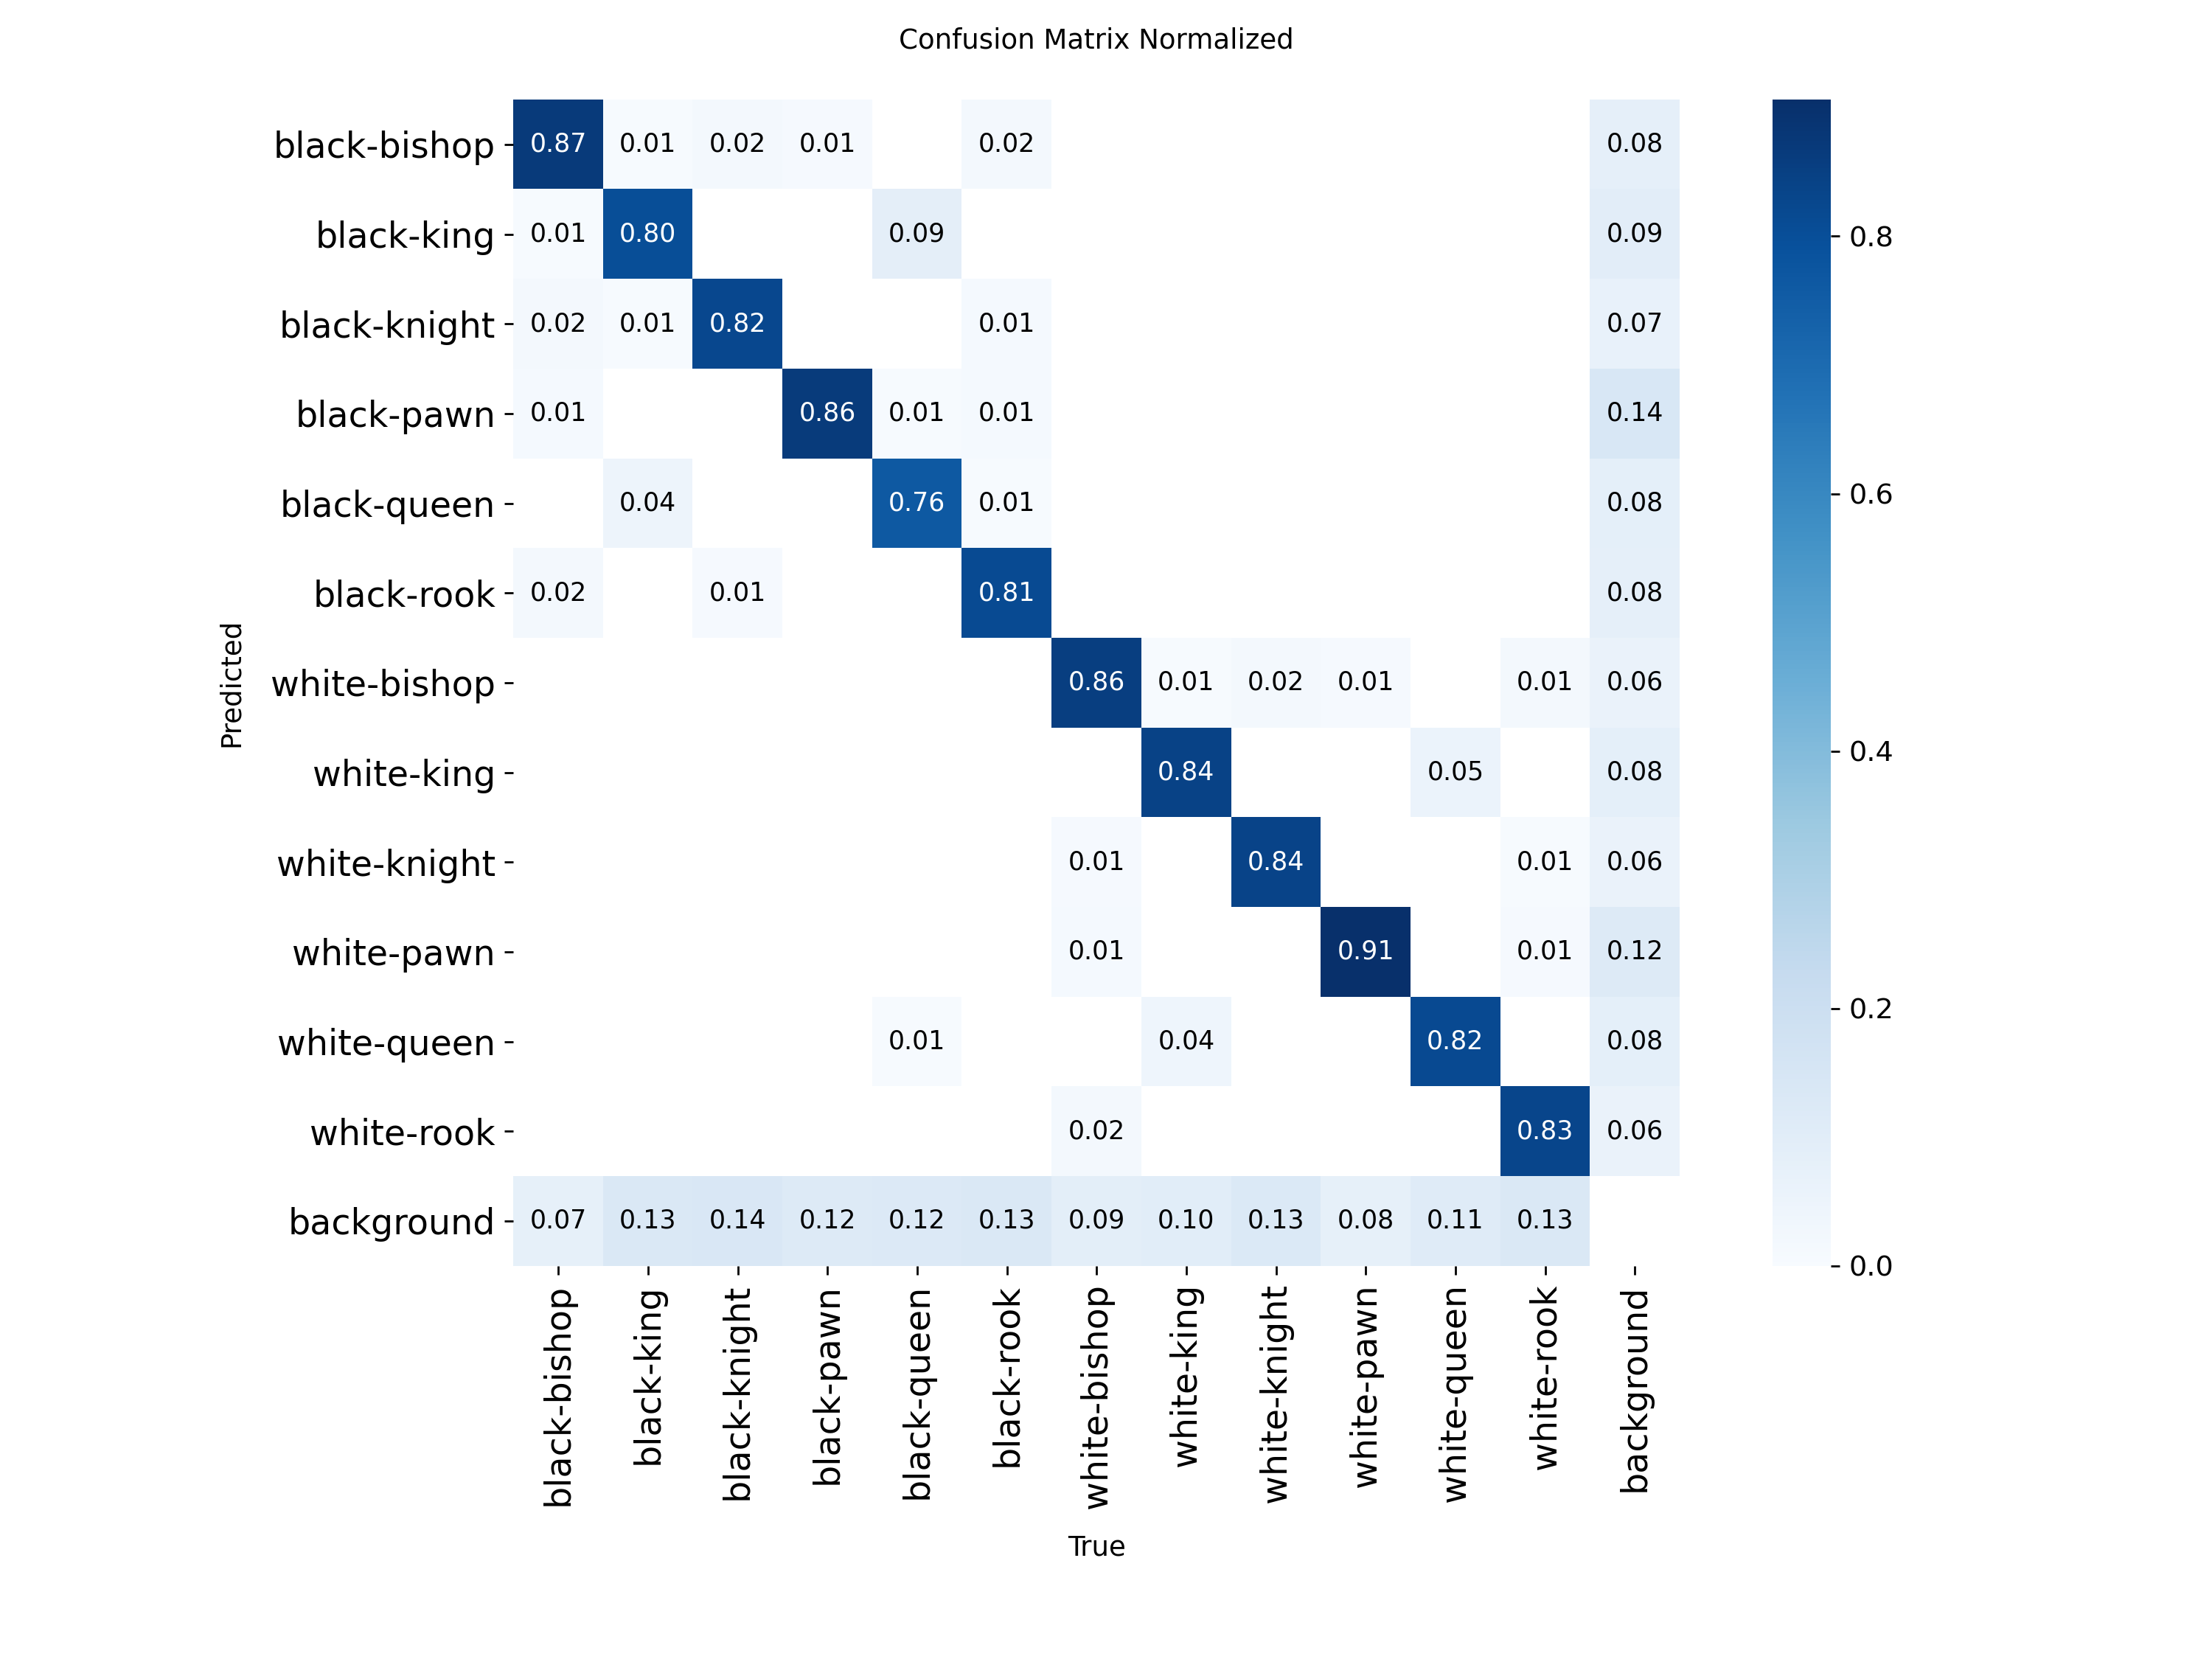

Could not find F1_curve.png. (Check if training finished successfully)

==================== 2. VISUAL PREDICTIONS (TEST SET) ====================


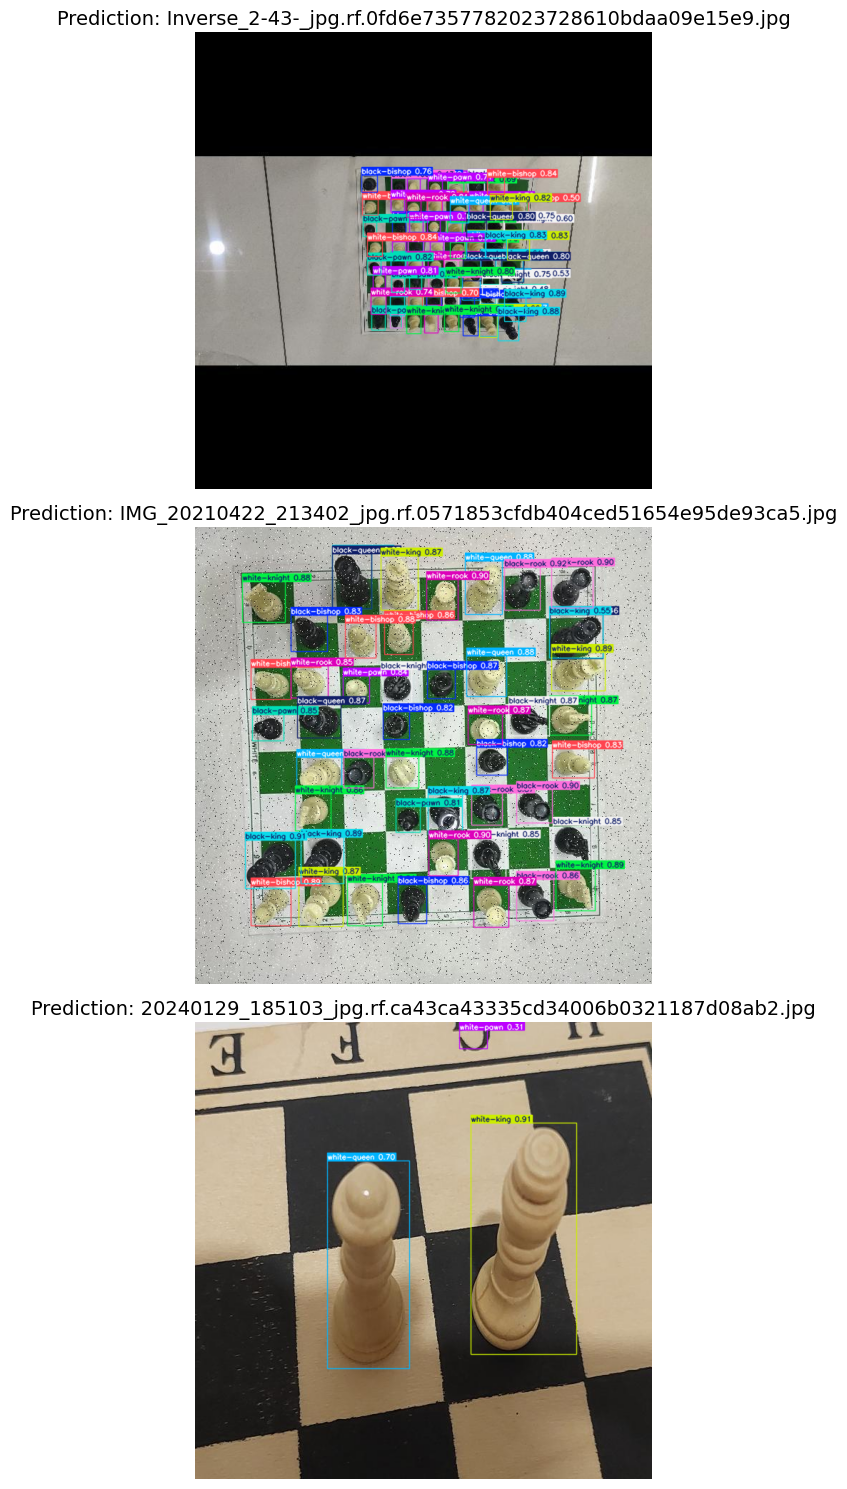

In [ ]:
import os
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'

RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', run_name)
BEST_MODEL_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')

print(f" Inspecting results from: {RUN_DIR}")

# Locate test images
drive_test_search = os.path.join(DRIVE_ROOT, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    TEST_IMAGES_PATH = found_drive_test[0]
    print(f"Test images found in Drive: {TEST_IMAGES_PATH}")
else:
    # Fallback
    local_test_path = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(local_test_path):
         local_test_path = '/content/datasets/c1-zhnfm-1/valid/images'
    TEST_IMAGES_PATH = local_test_path
    print(f"Test images found locally: {TEST_IMAGES_PATH}")


def display_training_metrics():
    """
    Displays the standard plots generated by Ultralytics during training.
    """
    print("\n" + "="*20 + " 1. TRAINING METRICS " + "="*20)

    # List of key plots to display
    plots_to_show = [
        ('results.png', 'Loss & Metrics Curves'),
        ('confusion_matrix_normalized.png', 'Confusion Matrix (Normalized)'),
        ('F1_curve.png', 'F1-Confidence Curve')
    ]

    for filename, title in plots_to_show:
        filepath = os.path.join(RUN_DIR, filename)
        if os.path.exists(filepath):
            print(f"\n--- {title} ---")
            display(Image(filename=filepath, width=800))
        else:
            print(f"Could not find {filename}. (Check if training finished successfully)")

def run_visual_inference(num_images=3):
    """
    Loads the best model from Drive, runs prediction on random test images, and displays them.
    """
    print("\n" + "="*20 + " 2. VISUAL PREDICTIONS (TEST SET) " + "="*20)

    # check if weights exist
    if not os.path.exists(BEST_MODEL_PATH):
        print(f"Best model weights not found at: {BEST_MODEL_PATH}")
        return

    # Load the best trained model
    model = YOLO(BEST_MODEL_PATH)

    # Get all images
    all_images = glob.glob(f"{TEST_IMAGES_PATH}/*.jpg")

    if len(all_images) == 0:
        print(f"No images found in {TEST_IMAGES_PATH}")
        return

    # Select random images
    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # Run Inference
    results = model.predict(
        source=selected_images,
        conf=0.25,      # Confidence threshold
        iou=0.45,       # NMS threshold
        save=False,     
        verbose=False
    )

    plt.figure(figsize=(15, 5 * num_images))

    for i, r in enumerate(results):
        im_array = r.plot(line_width=1, font_size=1) # r.plot() draws the bounding boxes
        im_rgb = im_array[..., ::-1] # BGR to RGB

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title(f"Prediction: {os.path.basename(selected_images[i])}", fontsize=14)

    plt.tight_layout()
    plt.show()

display_training_metrics()
run_visual_inference(num_images=3)

# Compare Labels vs Predictions

Target directory: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11_nano_v1
Run folder found. Starting analysis...
Loading test images from Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

=============== TRAINING RESULT: GROUND TRUTH vs PREDICTION ===============


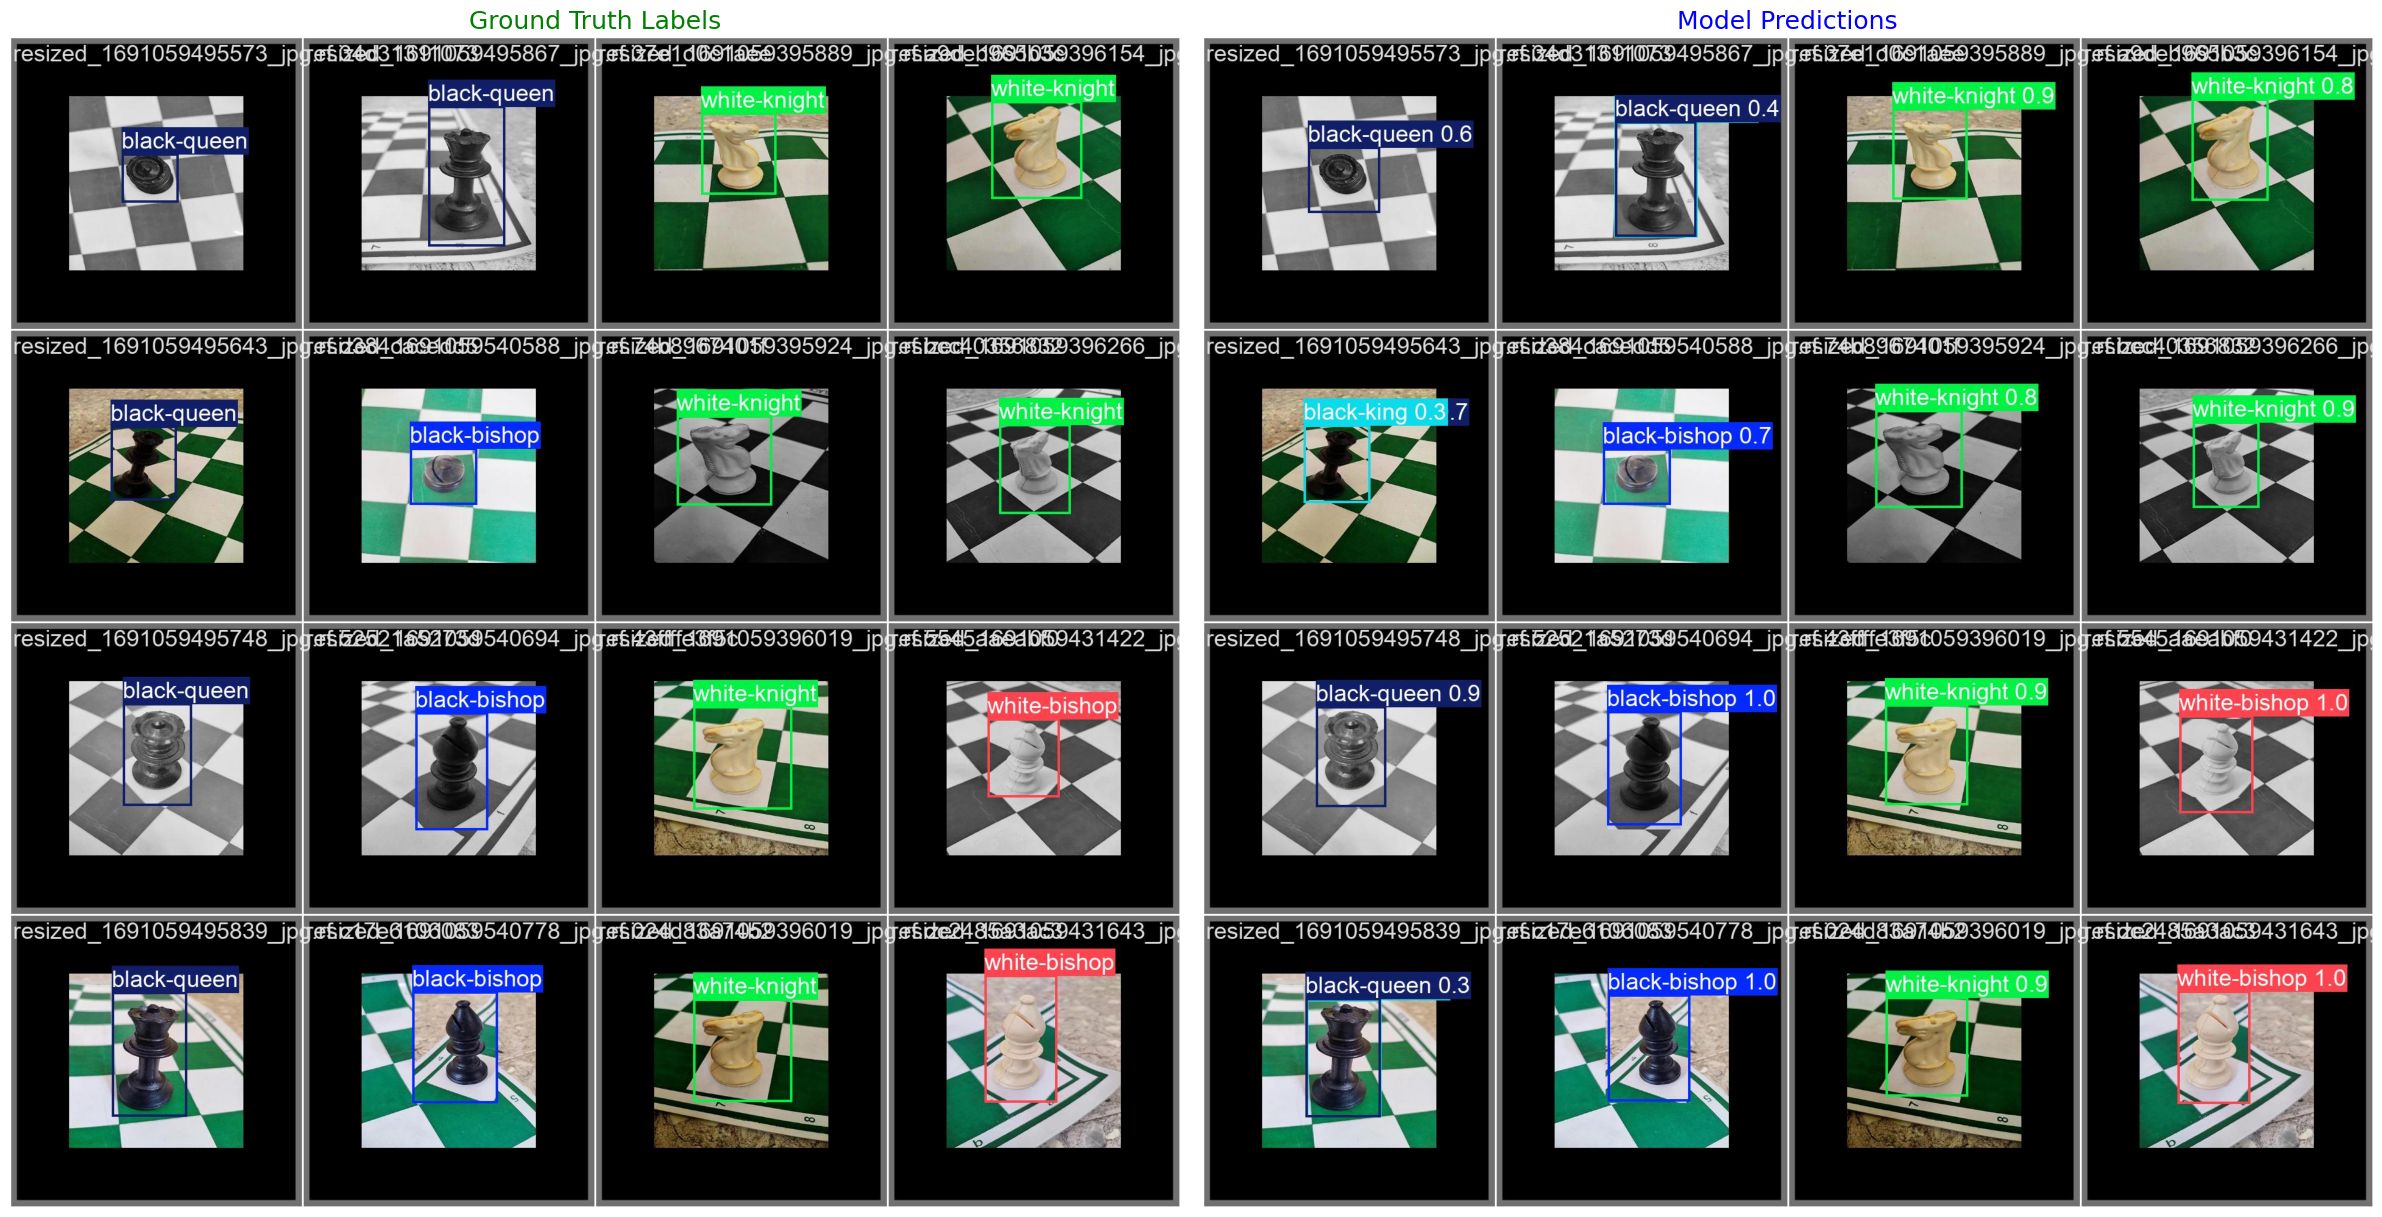


=============== LIVE TEST: Random 3 Images ===============


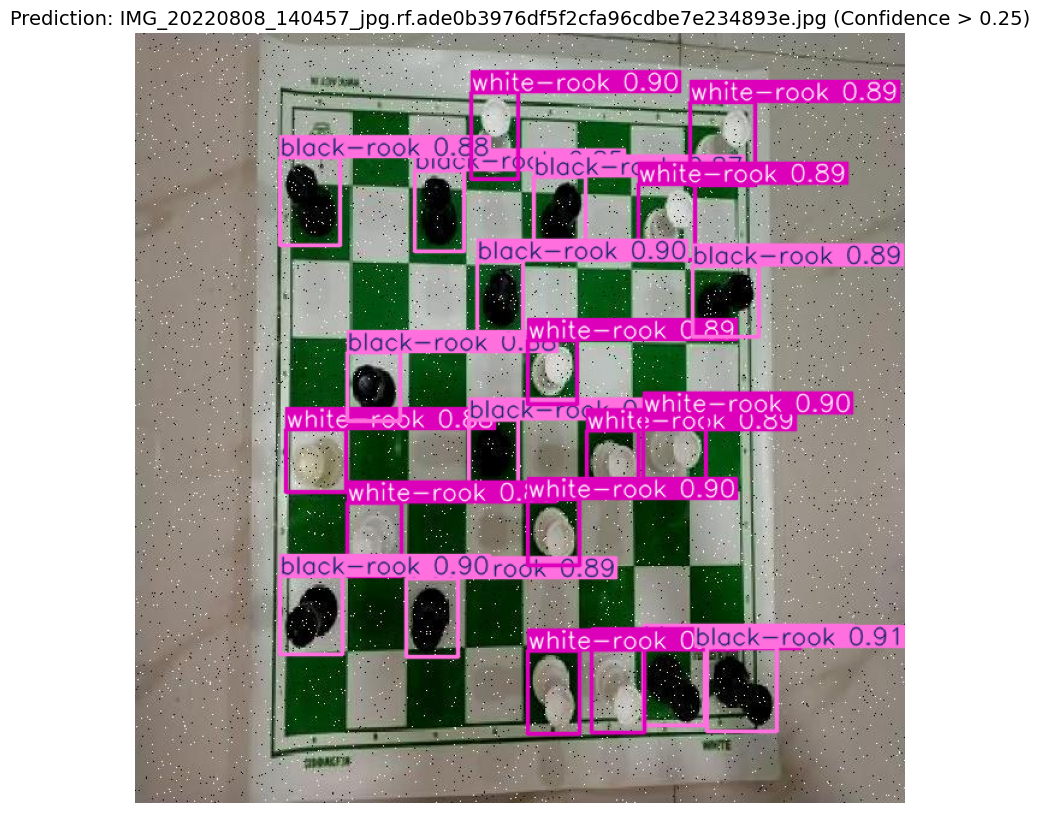

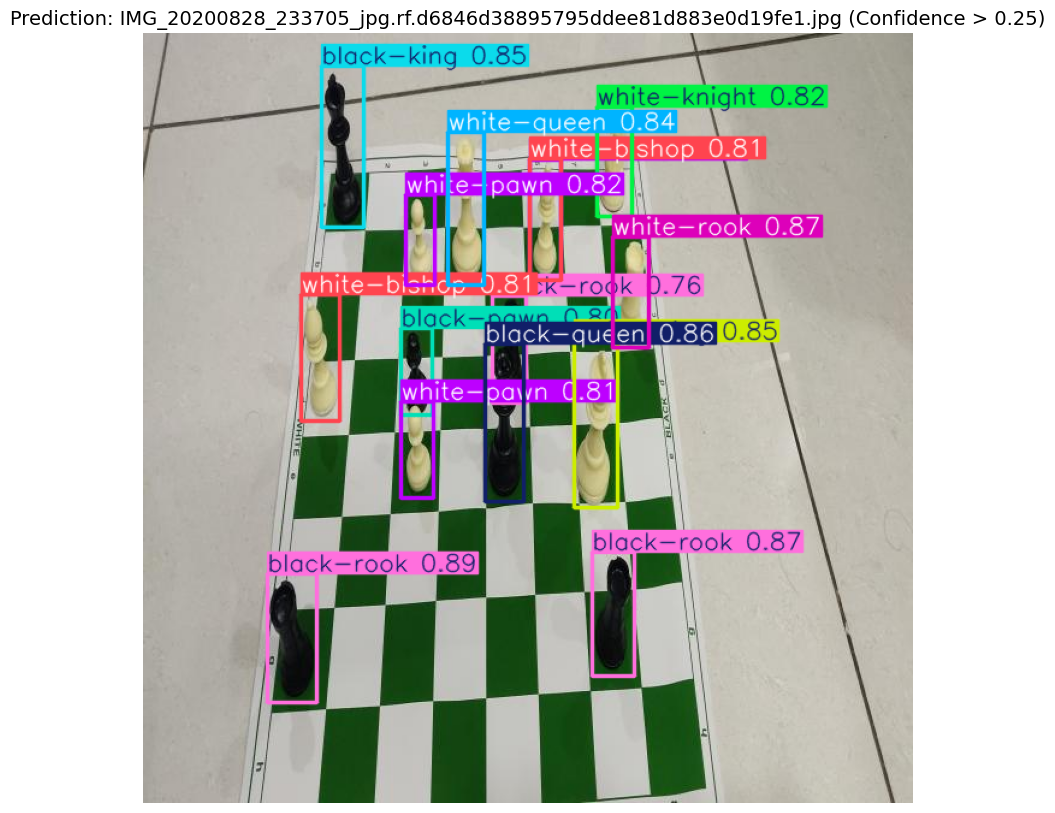

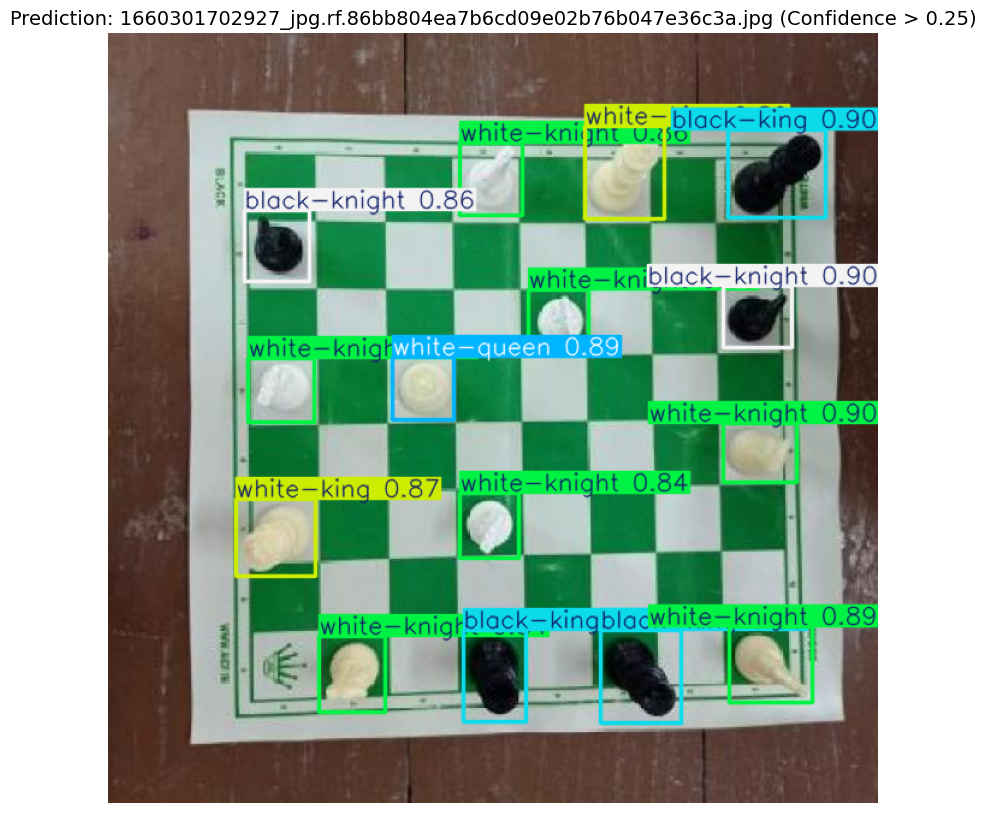

In [ ]:
import os
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'

RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', run_name)
BEST_WEIGHTS = os.path.join(RUN_DIR, 'weights', 'best.pt')

print(f"Target directory: {RUN_DIR}")

if not os.path.exists(RUN_DIR):
    print("ERROR: The specified run folder was not found.")
    print(f"Please verify the run name: '{run_name}'")
    print(f"Searched path: {RUN_DIR}")
else:
    print("Run folder found. Starting analysis...")

    # Locate test images
    test_search_path = os.path.join(DRIVE_ROOT, 'datasets', '*', 'test', 'images')
    found_test = glob.glob(test_search_path)

    if found_test:
        TEST_IMAGES_DIR = found_test[0]
        print(f"Loading test images from Drive: {TEST_IMAGES_DIR}")
    else:
        TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/test/images' # Fallback to local
        if not os.path.exists(TEST_IMAGES_DIR):
            TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/valid/images'
        print(f"Loading test images from local disk: {TEST_IMAGES_DIR}")

    # Visualization functions

    def show_ground_truth_vs_pred():
        print("\n" + "=" * 15 + " TRAINING RESULT: GROUND TRUTH vs PREDICTION " + "=" * 15)

        lbl_path = os.path.join(RUN_DIR, 'val_batch0_labels.jpg')
        pred_path = os.path.join(RUN_DIR, 'val_batch0_pred.jpg')

        if os.path.exists(lbl_path) and os.path.exists(pred_path):
            plt.figure(figsize=(24, 12))

            plt.subplot(1, 2, 1)
            plt.imshow(plt.imread(lbl_path))
            plt.title("Ground Truth Labels", fontsize=18, color='green')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(plt.imread(pred_path))
            plt.title("Model Predictions", fontsize=18, color='blue')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("WARNING: 'val_batch0' images were not found. Training may not have completed or images were not saved.")

    def show_custom_predictions(num_images=3, conf_thresh=0.25):
        print("\n" + "=" * 15 + f" LIVE TEST: Random {num_images} Images " + "=" * 15)

        if not os.path.exists(BEST_WEIGHTS):
            print(f"ERROR: 'best.pt' weights file not found: {BEST_WEIGHTS}")
            return

        # Load model
        model = YOLO(BEST_WEIGHTS)

        # List test images
        all_images = glob.glob(f"{TEST_IMAGES_DIR}/*.jpg")
        if not all_images:
            print(f"ERROR: No .jpg images found in directory: {TEST_IMAGES_DIR}")
            return

        # Randomly select images
        selected_files = random.sample(all_images, min(len(all_images), num_images))

        # Run inference
        results = model.predict(
            source=selected_files,
            conf=conf_thresh,
            iou=0.45,
            save=False,
            verbose=False
        )

        for i, r in enumerate(results):
            im_bgr = r.plot(line_width=2, font_size=2, conf=True, labels=True)
            im_rgb = im_bgr[..., ::-1]

            plt.figure(figsize=(12, 10))
            plt.imshow(im_rgb)
            plt.title(
                f"Prediction: {os.path.basename(selected_files[i])} (Confidence > {conf_thresh})",
                fontsize=14
            )
            plt.axis('off')
            plt.show()

    show_ground_truth_vs_pred()
    show_custom_predictions(num_images=3, conf_thresh=0.25)

# Analyze Model Confidence

Test folder: /content/C1-1/test/images
Loading model: /content/runs/detect/chess_yolo11_nano_v1/weights/best.pt
Processing 300 images...


Processing: 100%|██████████| 300/300 [00:02<00:00, 103.15it/s]


Plotting charts...


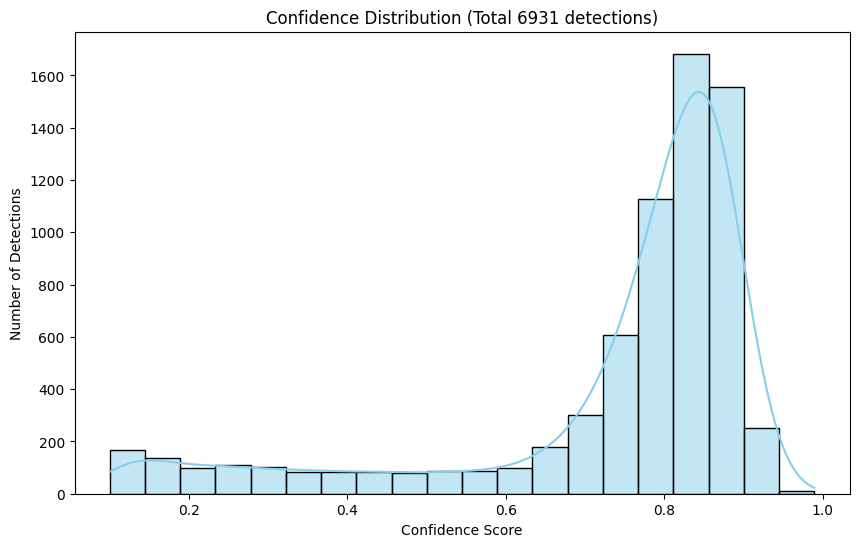



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



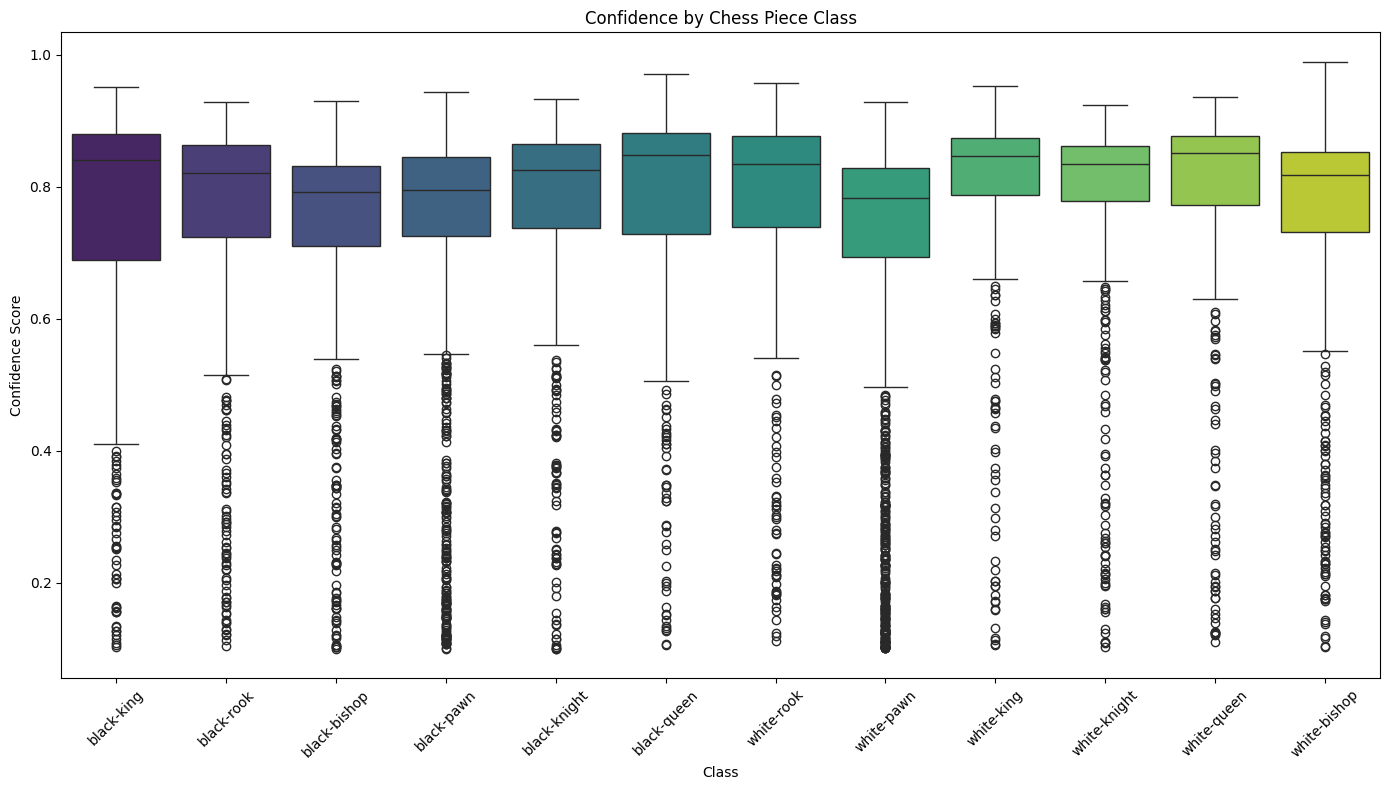

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import gc
from tqdm import tqdm


run_name = 'chess_yolo11_nano_v1' 
DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'
RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', 'detect', run_name)  
BEST_MODEL_PATH = '/content/runs/detect/chess_yolo11_nano_v1/weights/best.pt' 


if os.path.exists('/content/C1-1'):
    possible_dirs = glob.glob('/content/C1-1/test/images')
    if possible_dirs:
        TEST_IMAGES_DIR = possible_dirs[0]
    else:
        # If test is not found, try valid
        possible_dirs = glob.glob('/content/C1-1/valid/images')
        TEST_IMAGES_DIR = possible_dirs[0] if possible_dirs else None
else:
    TEST_IMAGES_DIR = None

print(f"Test folder: {TEST_IMAGES_DIR}")

def plot_confidence_analysis(model_path, images_dir, max_images=500):
    """
    Analyze detection confidence scores and plot distributions.

    max_images:
        Limit the number of images for faster runs.
        Set to None to use all images.
    """

    # Clear GPU/CPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    # Check model path
    if not os.path.exists(model_path):
        print(f"ERROR: Model not found -> {model_path}")
        return

    # Check images folder
    if not images_dir or not os.path.exists(images_dir):
        print("ERROR: Images folder not found.")
        return

    # Load the YOLO model
    print(f"Loading model: {model_path}")
    model = YOLO(model_path)

    image_files = glob.glob(f"{images_dir}/*.jpg") # Collect image files

    # Limit images if needed
    if max_images and len(image_files) > max_images:
        print(f"Warning: {len(image_files)} images found, only first {max_images} will be used.")
        image_files = image_files[:max_images]

    print(f"Processing {len(image_files)} images...")

    all_confs = []
    all_classes = []

    # Run predictions in stream mode
    results_generator = model.predict(
        source=image_files,
        conf=0.1,
        verbose=False,
        device=0,
        stream=True
    )

    for r in tqdm(results_generator, total=len(image_files), desc="Processing"): # Loop through results with a progress bar
        if r.boxes is not None and len(r.boxes) > 0:
            # Get confidences and class indices
            confs = r.boxes.conf.cpu().numpy()
            clss = r.boxes.cls.cpu().numpy().astype(int)

            # Map class indices to class names
            class_names = r.names

            all_confs.extend(confs)
            all_classes.extend([class_names[c] for c in clss])

    df = pd.DataFrame({'Confidence': all_confs, 'Class': all_classes})

    if df.empty:
        print("No detections were found.")
        return

    print("Plotting charts...")

    # Confidence histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Confidence', bins=20, kde=True, color='skyblue')
    plt.title(f'Confidence Distribution (Total {len(df)} detections)')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Detections')
    plt.show()

    # Confidence boxplot by class
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Class', y='Confidence', palette='viridis')
    plt.xticks(rotation=45)
    plt.title('Confidence by Chess Piece Class')
    plt.xlabel('Class')
    plt.ylabel('Confidence Score')
    plt.tight_layout()
    plt.show()

plot_confidence_analysis(BEST_MODEL_PATH, TEST_IMAGES_DIR, max_images=300)


# Advanced Evaluation

Analysis started for run: chess_yolo11_nano_v1
Model path: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11_nano_v1/weights/best.pt
Test Images: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

Computing class-wise mAP...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,584,492 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 76.3±44.7 MB/s, size: 81.0 KB)
val: Scanning /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 976/976 1.4Mit/s 0.0s
val: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images/IMG_20200909_000652_jpg.rf.915eb2770aef574ef4eae9a12de1e2b8.jpg: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 11.7it/s 5.2s
                   all     



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



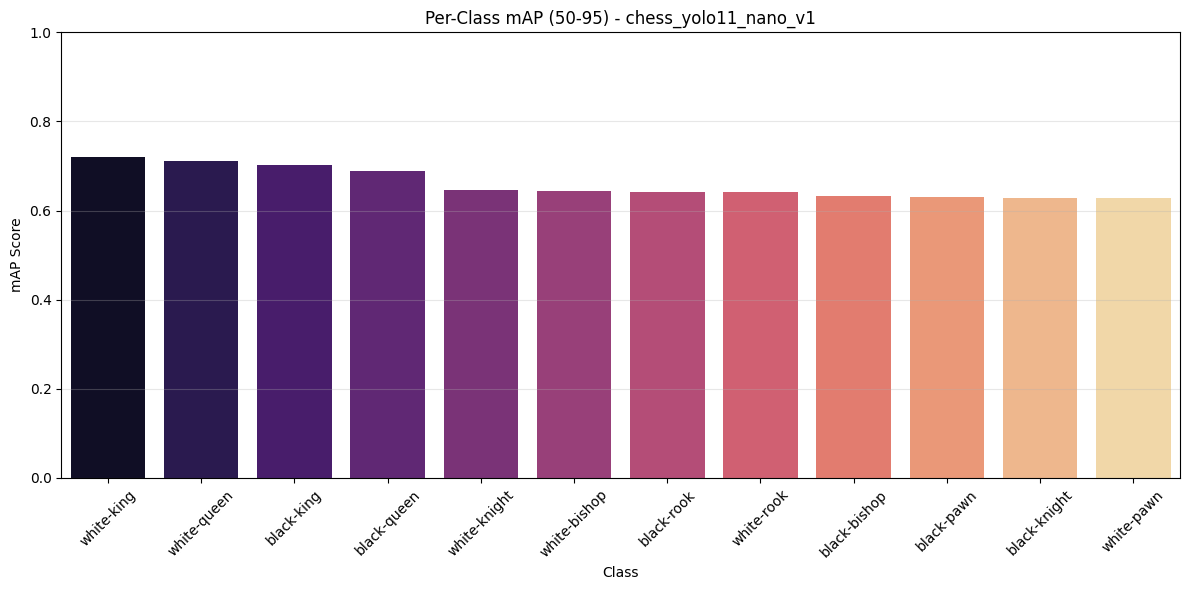


--- Confusion Matrix ---


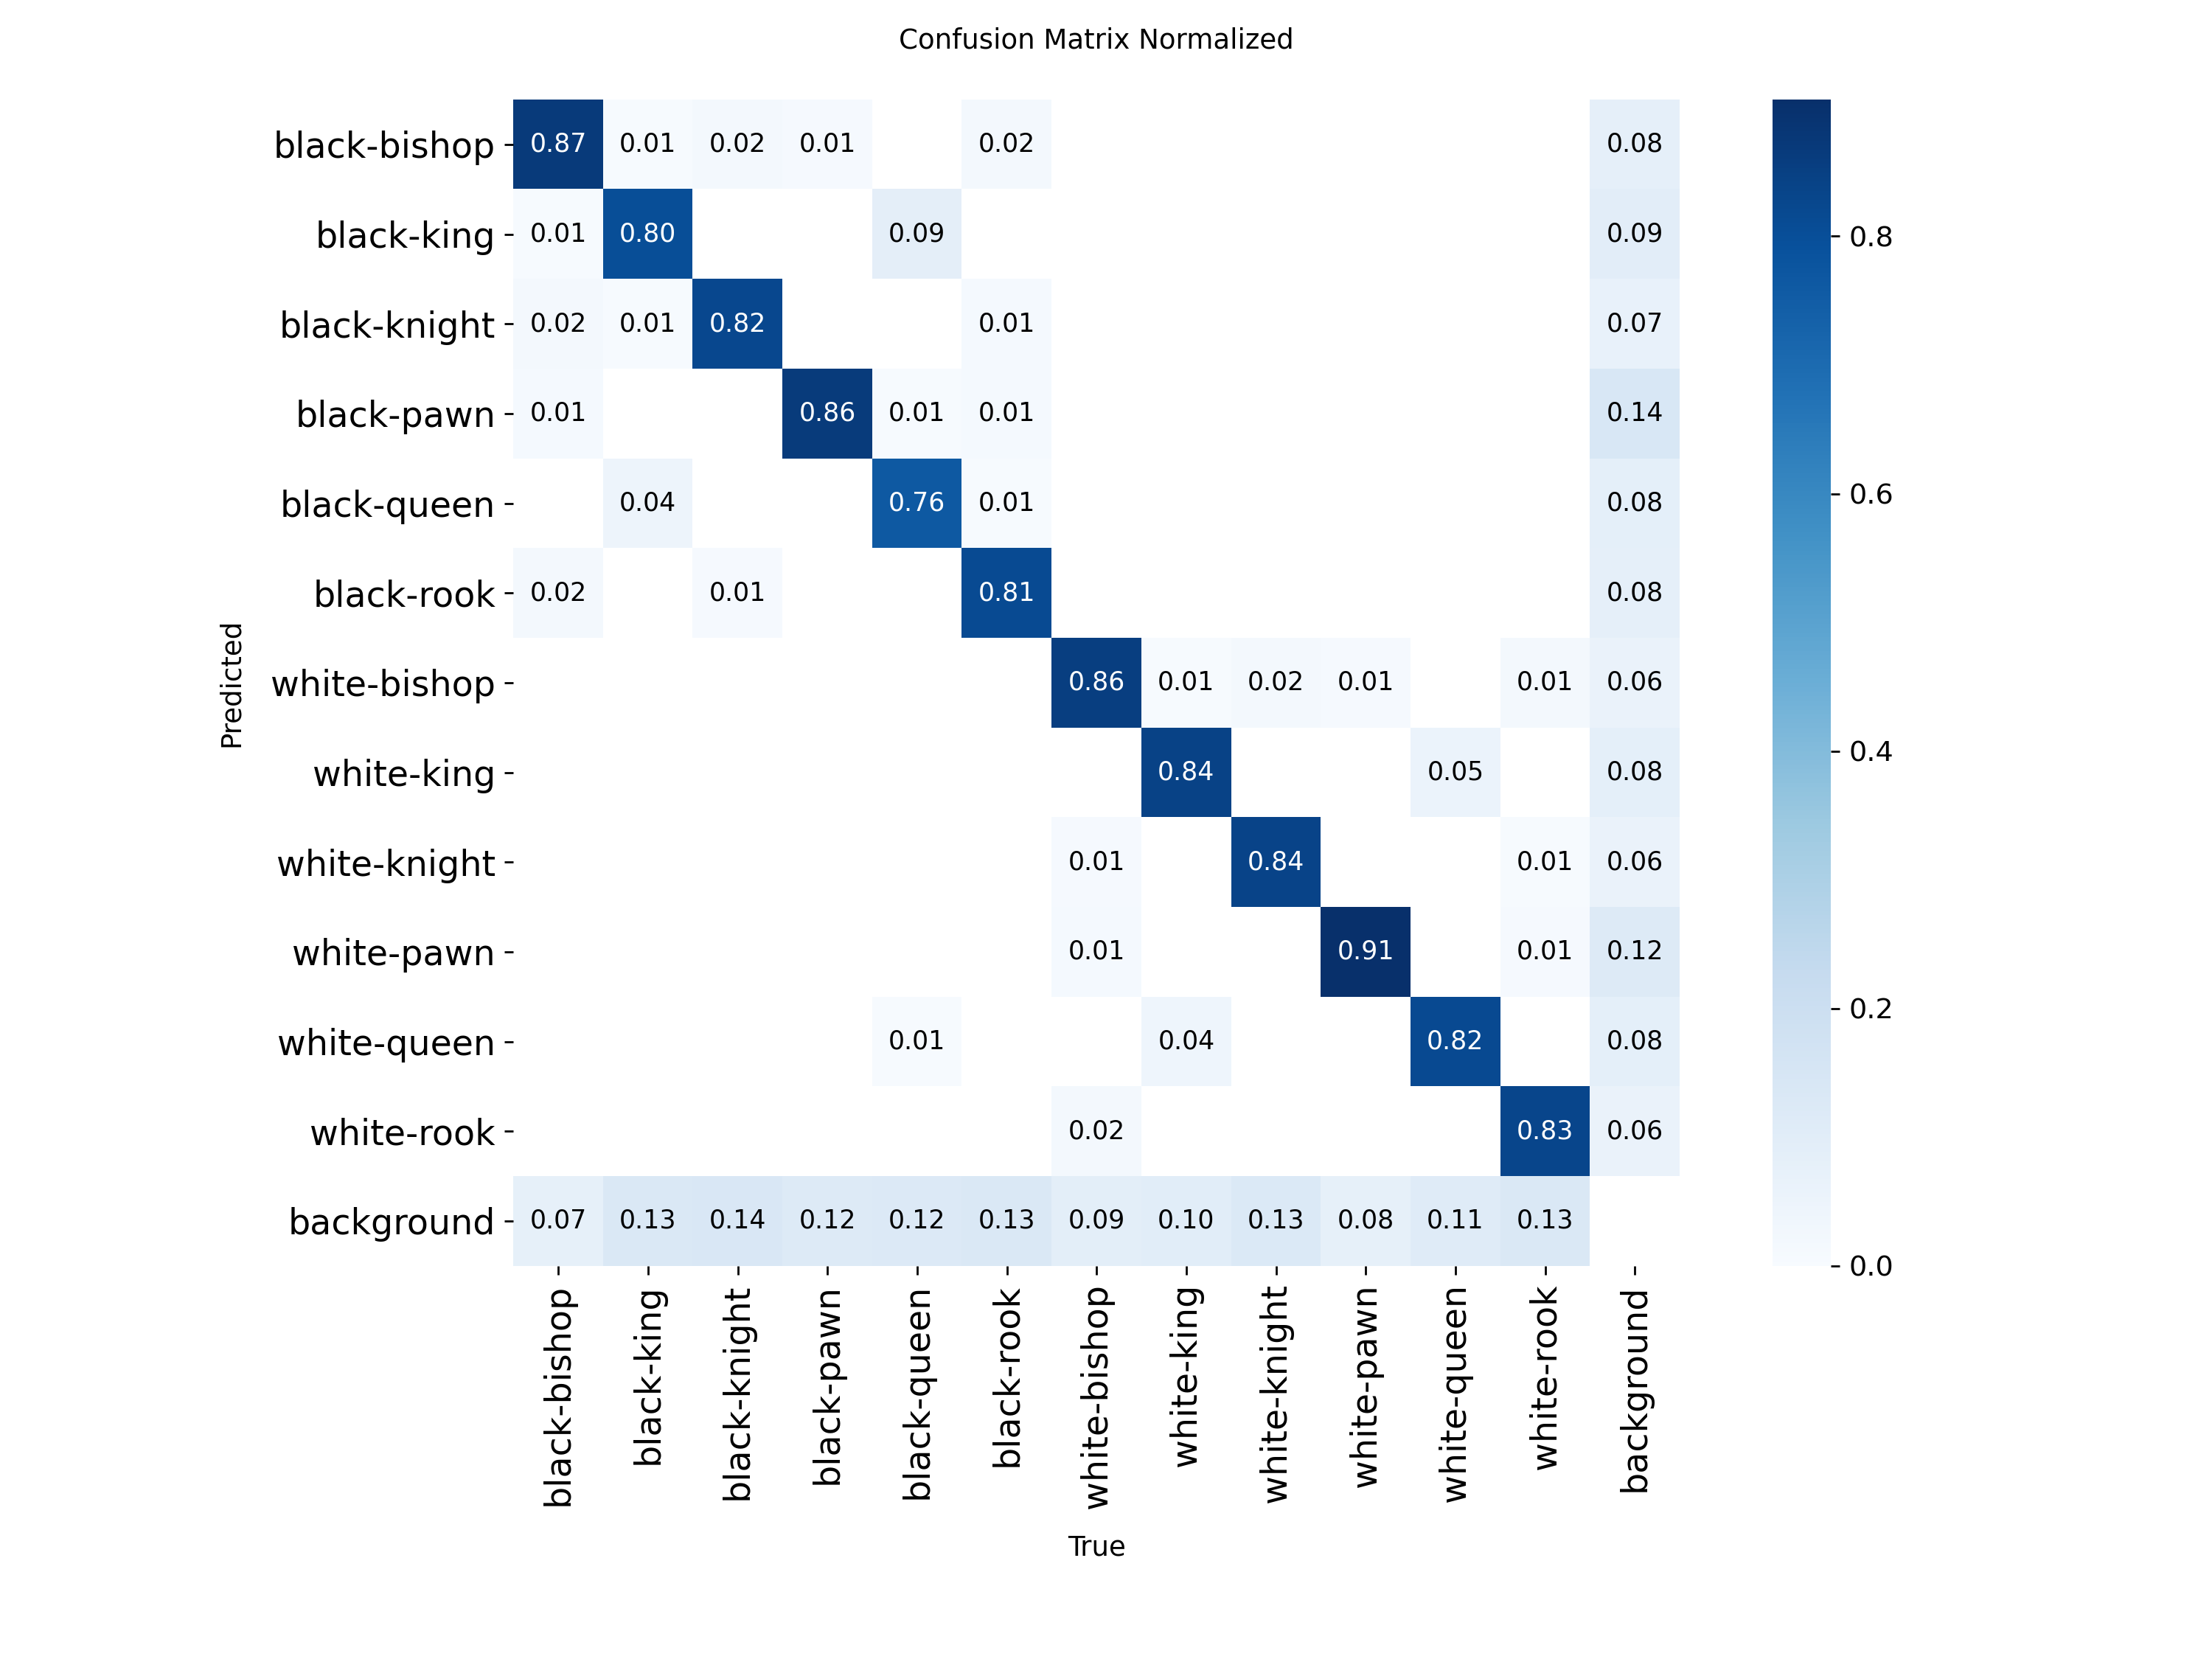

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import gc
from collections import Counter
from IPython.display import Image, display


DRIVE_ROOT = '/content/drive/MyDrive/Deep_Learning'
RUN_DIR = os.path.join(DRIVE_ROOT, 'runs', run_name)
BEST_MODEL_PATH = os.path.join(RUN_DIR, 'weights', 'best.pt')

# Locate Images and Labels
drive_test_search = os.path.join(DRIVE_ROOT, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    TEST_IMAGES_DIR = found_drive_test[0]
else:
    TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(TEST_IMAGES_DIR):
        TEST_IMAGES_DIR = '/content/datasets/c1-zhnfm-1/valid/images'

TEST_LABELS_DIR = TEST_IMAGES_DIR.replace('images', 'labels')

print(f"Analysis started for run: {run_name}")
print(f"Model path: {BEST_MODEL_PATH}")
print(f"Test Images: {TEST_IMAGES_DIR}")

def analyze_class_distribution(class_names):
    """
    Reads ground-truth label files to show dataset balance.
    """
    print("\n--- 1. Class Distribution Analysis (Ground Truth) ---")

    label_files = glob.glob(os.path.join(TEST_LABELS_DIR, "*.txt"))
    if not label_files:
        print("No label files found. Skipping distribution plot.")
        return

    class_counts = Counter()

    for lf in label_files:
        with open(lf, 'r') as f:
            lines = f.readlines()
            for line in lines:
                try:
                    cls_id = int(line.split()[0])
                    # Map ID to name using the model's class names
                    if cls_id < len(class_names):
                        class_counts[class_names[cls_id]] += 1
                except ValueError:
                    continue

    if not class_counts:
        print("No classes found in label files.")
        return

    # Create DataFrame
    df_dist = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).reset_index()
    df_dist.columns = ['Class', 'Count']
    df_dist = df_dist.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')
    plt.title('Class Distribution in Test Set (Ground Truth)')
    plt.xlabel('Chess Piece')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_worst_predictions(model, img_dir, num_samples=6):
    """
    Finds and plots predictions with the lowest confidence scores (Hardest samples).
    Memory Safe Version: Processes images one by one.
    """
    print(f"\n--- 2. Worst Predictions Gallery (Lowest Confidence) ---")
    print("Running sequential inference to find hard samples (Memory Safe)...")

    image_files = glob.glob(os.path.join(img_dir, "*.jpg"))
    if not image_files:
        print("No images found.")
        return

    # Store low confidence candidates
    low_conf_candidates = []

    # Loop image by image to save memory
    for i, img_path in enumerate(image_files):
        try:
            results = model.predict(img_path, conf=0.1, verbose=False, device=0)

            for r in results:
                if r.boxes:
                    for box in r.boxes:
                        conf = box.conf.item()
                        cls_id = int(box.cls.item())
                        cls_name = model.names[cls_id]

                        # Store metadata
                        low_conf_candidates.append({
                            'conf': conf,
                            'class': cls_name,
                            'path': img_path
                        })
        except Exception as e:
            # If a single image fails, skip it but continue
            continue

    # Sort by confidence Ascending
    low_conf_candidates.sort(key=lambda x: x['conf'])

    # Keep only unique images (top N)
    unique_worst_images = []
    seen_paths = set()

    for item in low_conf_candidates:
        if item['path'] not in seen_paths:
            unique_worst_images.append(item)
            seen_paths.add(item['path'])
        if len(unique_worst_images) >= num_samples:
            break

    if not unique_worst_images:
        print("No detections found.")
        return

    print(f"Plotting {len(unique_worst_images)} worst cases")

    rows = (len(unique_worst_images) + 2) // 3
    plt.figure(figsize=(15, 5 * rows))

    for i, item in enumerate(unique_worst_images):

        r = model.predict(item['path'], conf=0.1, verbose=False)[0] # Rerun prediction just for this image to get the plot array

        im_array = r.plot() # BGR numpy array
        im_rgb = im_array[..., ::-1] # RGB

        plt.subplot(rows, 3, i + 1)
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title(f"Low Conf: {item['conf']:.2f} ({item['class']})\n{os.path.basename(item['path'])}",
                  fontsize=11, color='red')

    plt.tight_layout()
    plt.show()

def generate_advanced_plots():
    # Clear GPU memory before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(BEST_MODEL_PATH):
        print("Model file not found.")
        return

    # Load Model
    model = YOLO(BEST_MODEL_PATH)

    # 1: Standard Metrics (mAP)
    print("\nComputing class-wise mAP")
    metrics = model.val(
        data=os.path.join(os.path.dirname(os.path.dirname(TEST_IMAGES_DIR)), 'data.yaml'),
        split='test',
        verbose=False,
        plots=False
    )

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    class_names = metrics.names
    map5095_per_class = metrics.box.maps

    df_map = pd.DataFrame({
        'Class': [class_names[i] for i in range(len(map5095_per_class))],
        'mAP 50-95': map5095_per_class
    }).sort_values('mAP 50-95', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_map, x='Class', y='mAP 50-95', palette='magma')
    plt.title(f'Per-Class mAP (50-95) - {run_name}')
    plt.xlabel('Class')
    plt.ylabel('mAP Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    #2: Confusion Matrix
    conf_matrix_path = os.path.join(RUN_DIR, 'confusion_matrix_normalized.png')
    if os.path.exists(conf_matrix_path):
        print("\n--- Confusion Matrix ---")
        display(Image(filename=conf_matrix_path, width=800))

generate_advanced_plots()